# Dask imaging demonstration

This notebook explores the use of dask for parallelisation. We work through the steps of imaging, ending up with a major/minor cycle algorithm using dask.

For each step, we first create a graph and then execute it to demonstrate correctness. More evolved versions of these functions are in  pipelines/dask_graphs.py

In [1]:
%matplotlib inline

import os
import sys

from dask import delayed

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.data_models import Image, BlockVisibility, Visibility
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.operations import create_blockvisibility, create_visibility_from_rows, \
    copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, \
    normalize_sumwt, create_image_from_visibility, \
    predict_skycomponent_blockvisibility, residual_image, invert_timeslice_single, \
    predict_timeslice_single, predict_timeslice_single, advise_wide_field
from arl.pipelines.dask_graphs import create_invert_graph

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We create the visibility. 

In [2]:
def read_visibility(freq=1e8, chan_width=1e6, time=0.0):
    lowcore = create_named_configuration('LOWBD2-CORE')
    times = [time]
    frequency = numpy.array([freq])
    channel_bandwidth = numpy.array([chan_width])


    reffrequency = numpy.max(frequency)
    phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
    return delayed(create_blockvisibility)(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame("stokesI"))

vis_graph_list=list()
for freq in numpy.linspace(0.8e8,1.2e8,7):
    vis_graph_list.append(read_visibility(freq))

Create a grid of components and predict each in turn, using the full phase term including w.

In [3]:
def get_LSM(vt):
    npixel = 512
    cellsize=0.001
    flux = numpy.array([[100.0]])
    facets = 4

    model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1, frequency=vt.frequency,
                                        polarisation_frame=PolarisationFrame("stokesI"))
    spacing_pixels = npixel // facets
    log.debug('Spacing in pixels = %s' % spacing_pixels)
    spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
    centers = -1.5, -0.5, +0.5, +1.5
    comps = list()
    for iy in centers:
        for ix in centers:
            pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
            pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
            sc = pixel_to_skycoord(pra, pdec, model.wcs)
            log.debug("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
            comps.append(create_skycomponent(flux=flux, frequency=vt.frequency, direction=sc, 
                                             polarisation_frame=PolarisationFrame("stokesI")))
    predict_skycomponent_blockvisibility(vt, comps)
    return [model,]

Define a Dask enabled invert looking like invert_2d but with additional arguments for the invert for a single chunk, and the iterator. The iterator is used to split the visibility up into pieces before calling the
single chunk invert.

The function invert_graph is not a graph but it takes graphs as input and emits a graph to do the calculation. The dask.delayed method compute() must be called to actually execute the graph. 

This will need graphs to calculate the dirty (or residual) image and the psf. Here we just add the images weighted by the sum of weights for each image. For e.g. MFS, would put the images into separate planes.

In [4]:
def create_invert_graph(vis_graph_list, model_graph, dopsf=True, invert_single=invert_timeslice_single, 
                        normalize=True, **kwargs):
    """ Sum results from invert, weighting appropriately
    
    """
    def sum_invert_results(image_list):
        for i, arg in enumerate(image_list):
            if i== 0:
                im=copy_image(arg[0])
                im.data *= arg[1]
                sumwt = arg[1]
            else:
                im.data += arg[1]*arg[0].data
                sumwt += arg[1]
        
        im=normalize_sumwt(im, sumwt)
        return im, sumwt                            
        
    image_graph_list = list()
    for vis_graph in vis_graph_list:
        model_graph = delayed(get_LSM, pure=True, nout=1)(vis_graph)
        image_graph_list.append(delayed(invert_single, pure=True, nout=2)(vis_graph, model_graph[0], 
                                                                           dopsf=dopsf, normalize=normalize, 
                                                                           **kwargs))

    return delayed(sum_invert_results)(image_graph_list)

We feed this with a list of visibility graphs 

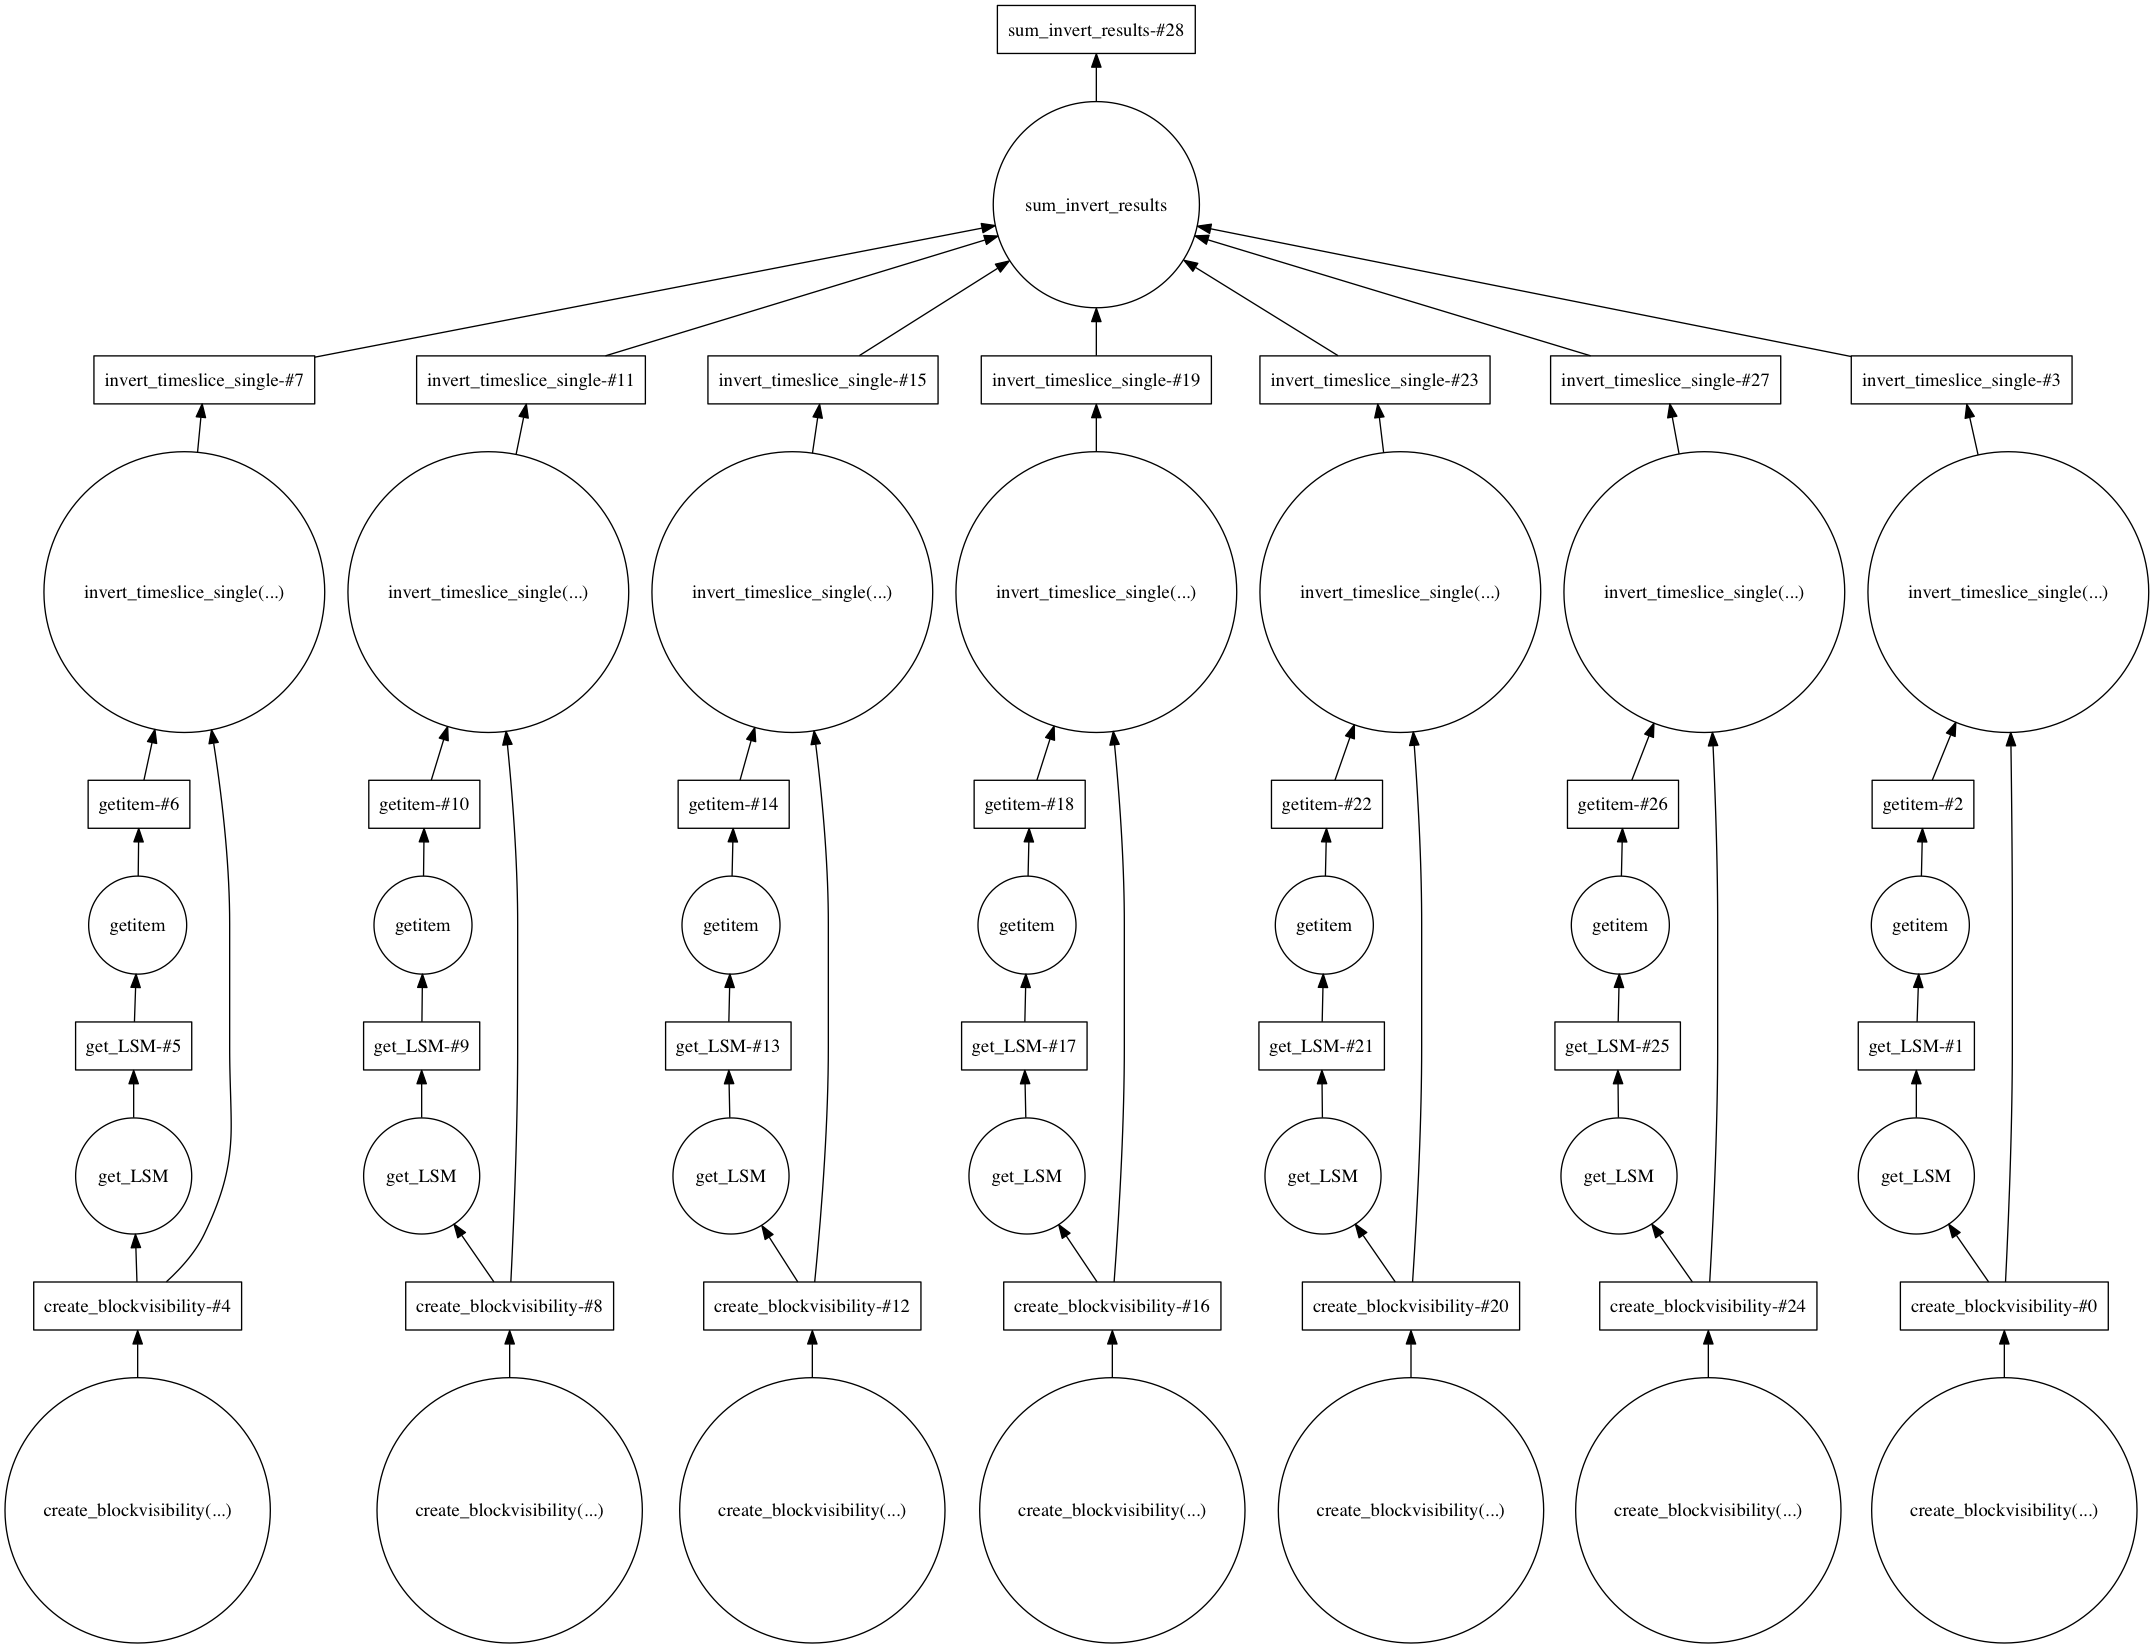

In [5]:
model_graph = delayed(get_LSM)(vis_graph_list[0])
                             
dirty_graph=create_invert_graph(vis_graph_list, model_graph, dopsf=False, 
                                           invert_single=invert_timeslice_single, 
                                           normalize=True)

psf_graph=create_invert_graph(vis_graph_list, model_graph, dopsf=True, 
                                           invert_single=invert_timeslice_single, 
                                           normalize=True)


psf_graph.visualize()


We now create and visualize a graph to perform a deconvolution using the summed dirty image and PSF.

In [6]:
def create_deconvolve_graph(dirty_graph, psf_graph, model_graph, **kwargs):
    def deconvolve_model_only(dirty, psf, model, **kwargs):
        log.info('deconvolve_graph: Starting deconvolution')
        result = deconvolve_cube(dirty, psf, **kwargs)
        log.info('deconvolve_graph: Finished deconvolution')
        result[0].data += model.data
        return result
    return delayed(deconvolve_model_only, pure=True, nout=2)(dirty_graph[0], psf_graph[0], model_graph[0], **kwargs)

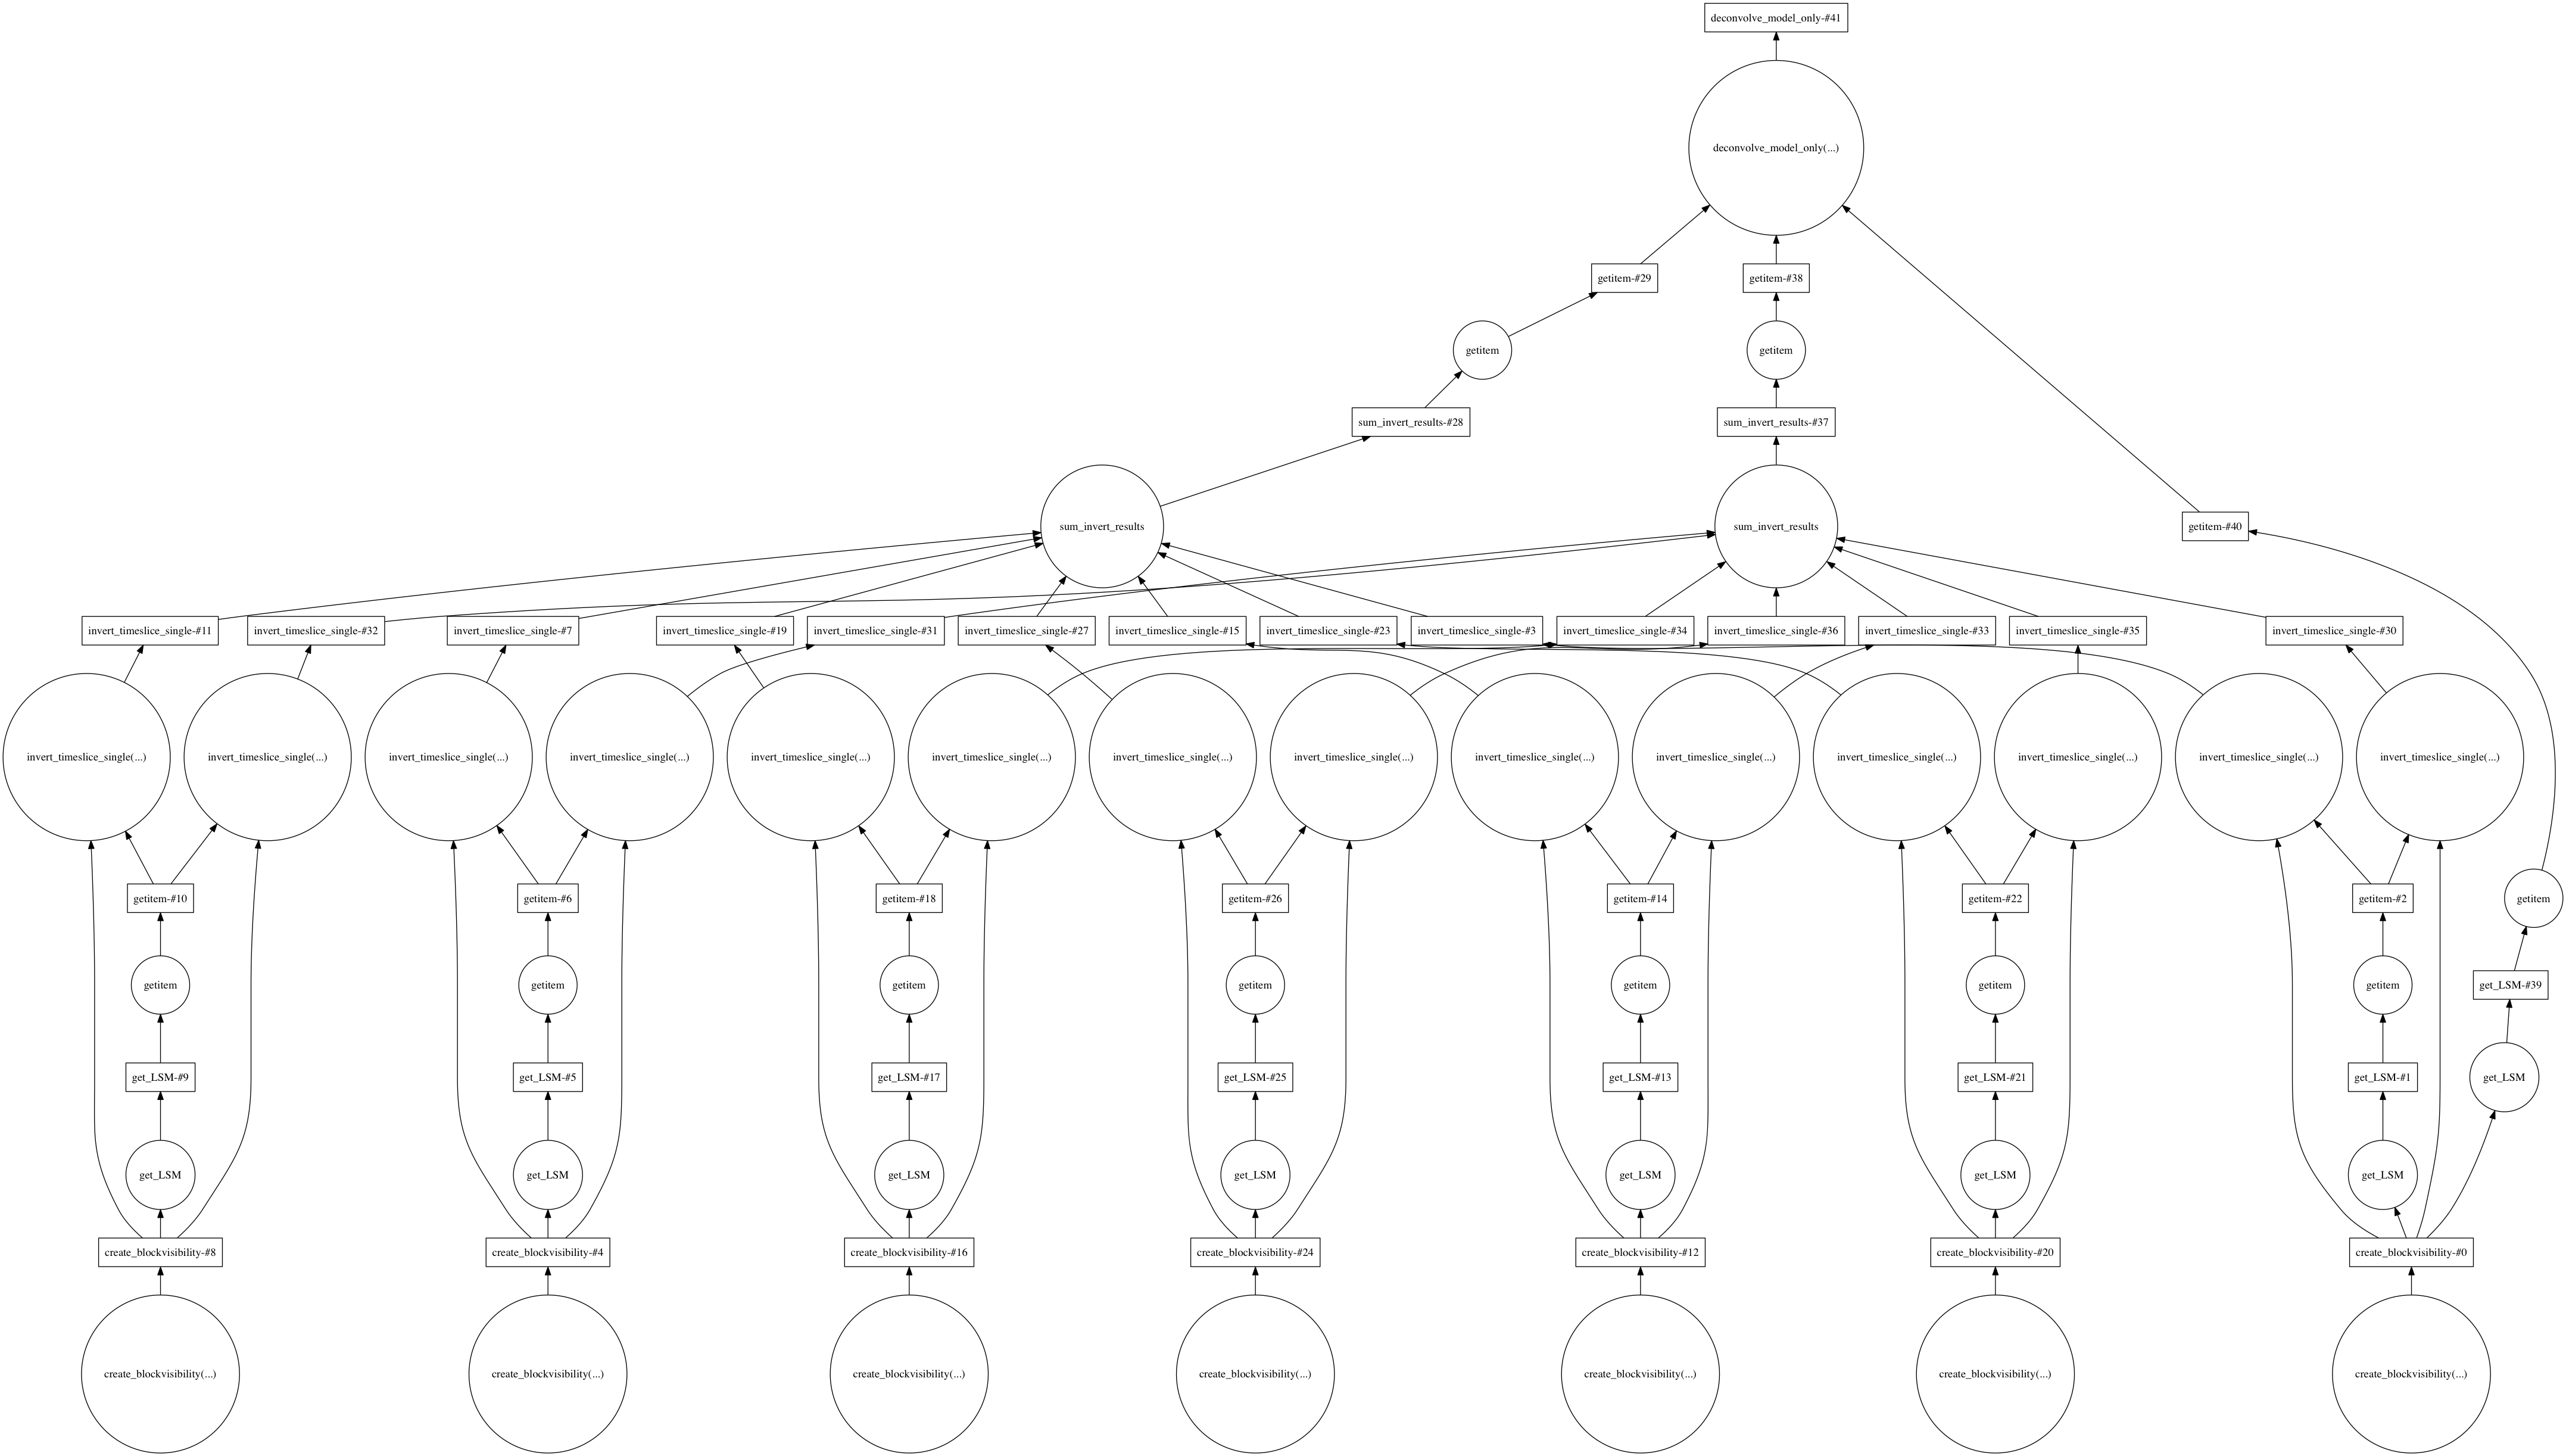

In [7]:
clean_model_graph = create_deconvolve_graph(dirty_graph, psf_graph, model_graph, niter=1000, 
                                            algorithm='hogbom', gain=0.1)
clean_model_graph.visualize()

Next we will need a graph to calculate residuals.

In [8]:
def create_residual_graph(vis_graph_list, model_graph, **kwargs):
    """ Sum results from invert, weighting appropriately
    
    """
    def sum_residual_results(image_list):
        for i, arg in enumerate(image_list):
            if i== 0:
                im=copy_image(arg[1])
                im.data *= arg[2]
                sumwt = arg[2]
            else:
                im.data += arg[2]*arg[1].data
                sumwt += arg[2]
        
        im=normalize_sumwt(im, sumwt)
        return im, sumwt                            
        
    image_graph_list = list()
    for vis_graph in vis_graph_list:
        image_graph_list.append(delayed(residual_image, pure=True, nout=3)(vis_graph, model_graph[0], **kwargs))

    return delayed(sum_residual_results)(image_graph_list)

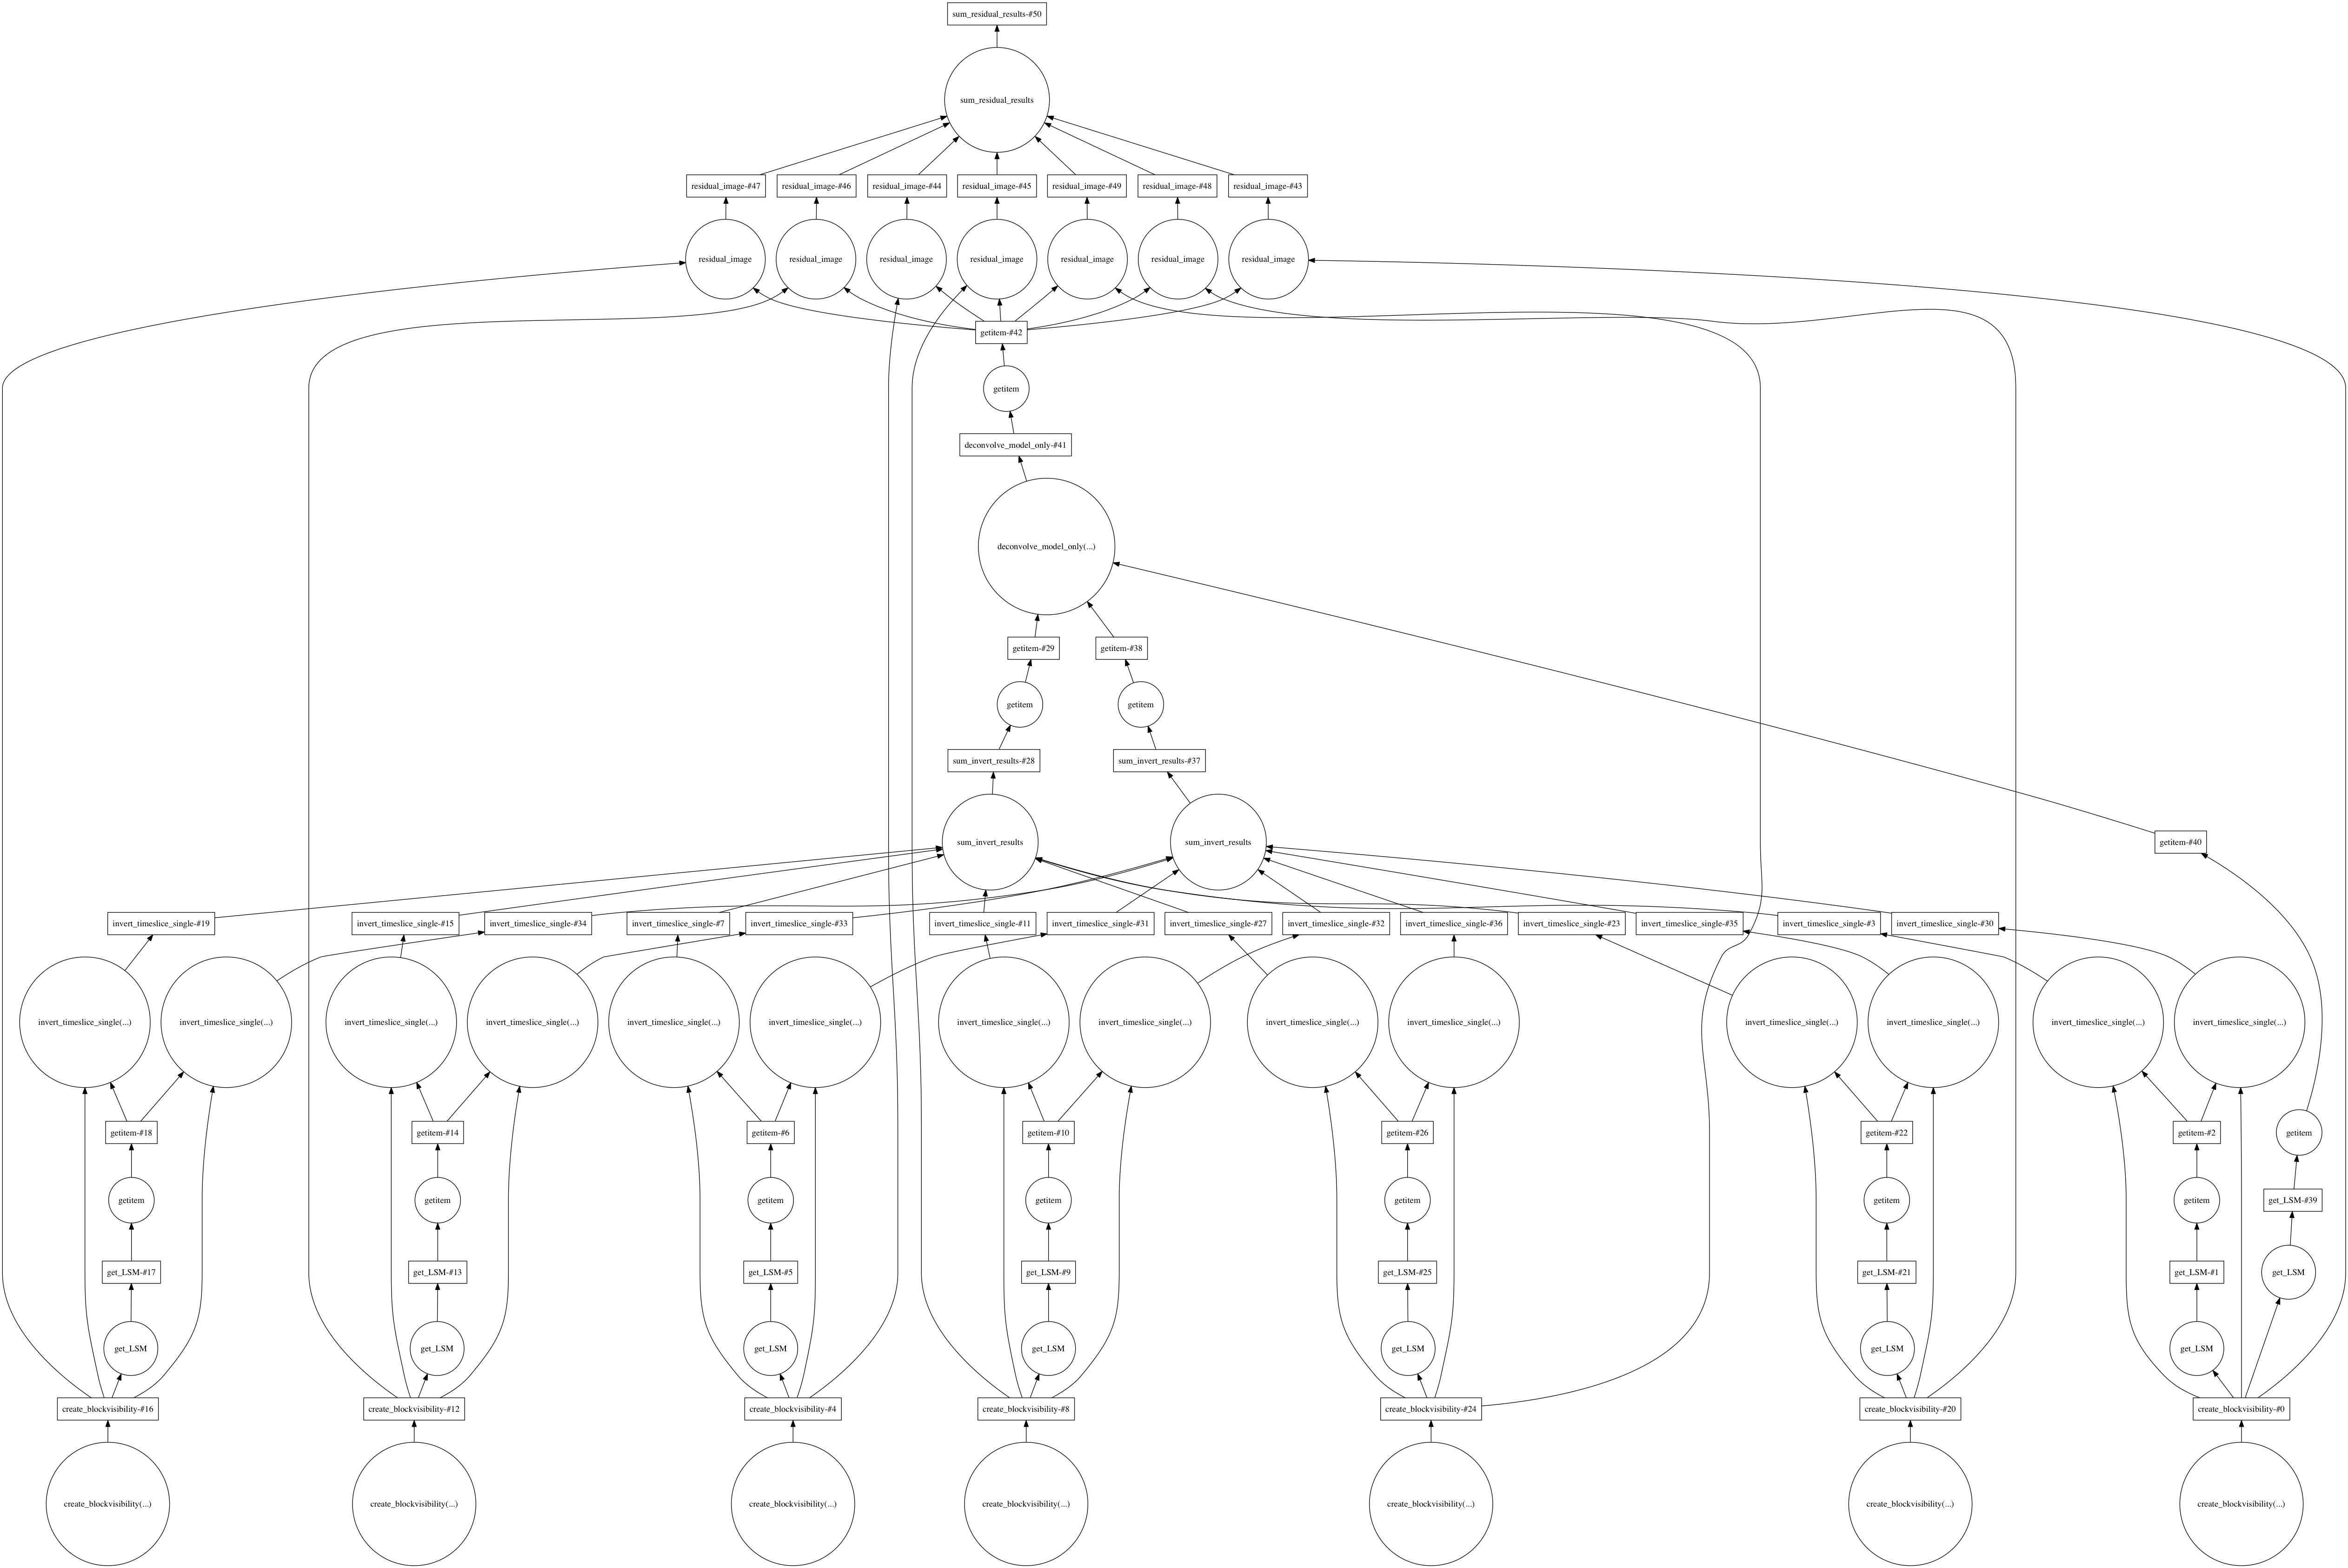

In [9]:
residual_graph=create_residual_graph(vis_graph_list, clean_model_graph)
residual_graph.visualize()

Note that the arguments predict_residual and invert_residual are passed to the ftprocessor.residual function.

Next we create a function that can make graphs for solve_image

In [10]:
def create_solve_image_graph(vis_graph_list, model_graph, psf_graph,
                             create_residual_graph=create_residual_graph, 
                             create_deconvolve_graph=create_deconvolve_graph, **kwargs):

    res_graph_list = list()
    model_graph_list = list()
    
    nmajor = get_parameter(kwargs, "nmajor", 5)
    
    res_graph_list.append(create_residual_graph(vis_graph_list, model_graph, **kwargs))    
    model_graph_list.append(create_deconvolve_graph(res_graph_list[-1], psf_graph, model_graph, **kwargs))
    
    if nmajor > 1:
        for cycle in range(1, nmajor):
            res_graph_list.append(create_residual_graph(vis_graph_list, model_graph_list[-1], **kwargs))    
            model_graph_list.append(create_deconvolve_graph(res_graph_list[-1], psf_graph, 
                                                     model_graph_list[cycle-1], **kwargs))
    
    return model_graph_list[-1]

Now we can create and visualize the graph that will do the deconvolution

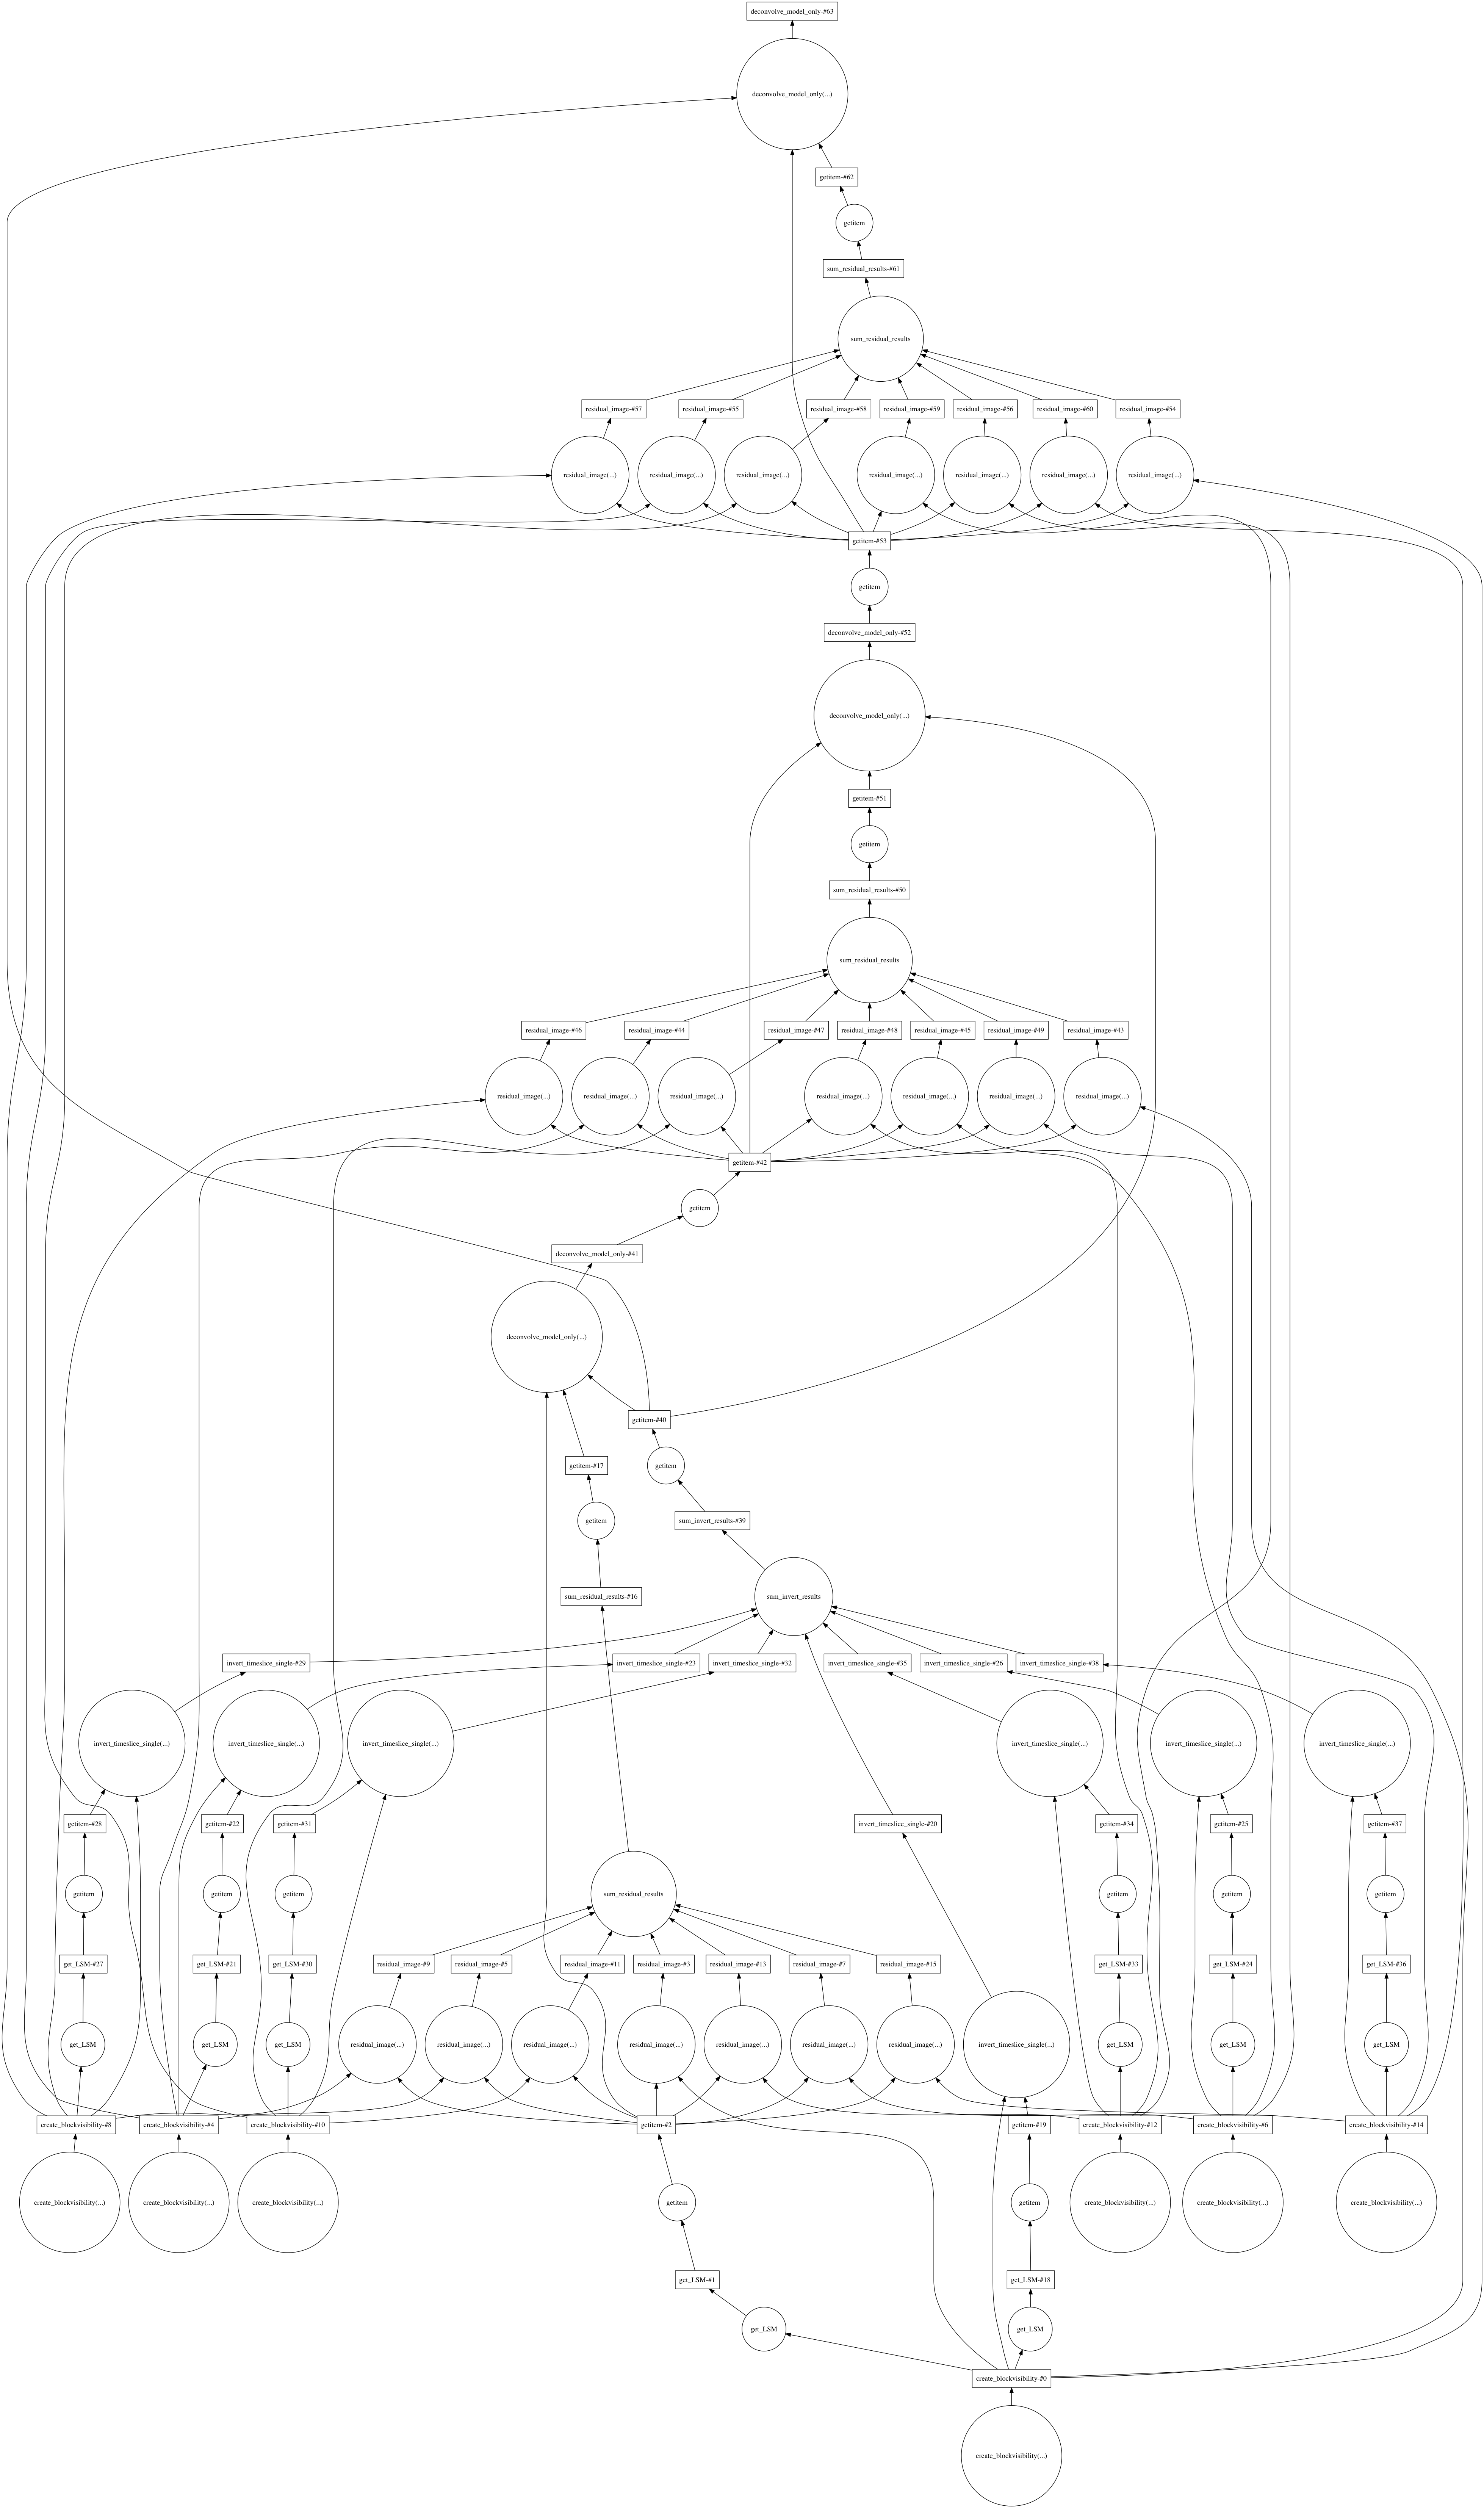

In [11]:
solution_graph = create_solve_image_graph(vis_graph_list, model_graph=model_graph, psf_graph=psf_graph,
                                          invert_residual=invert_timeslice_single, 
                                          predict_residual=predict_timeslice_single, 
                                          algorithm='hogbom',
                                          niter=1000, fractional_threshold=0.1,
                                          threshold=1.0, nmajor=3, gain=0.1)
solution_graph.visualize()

We update the residual graph and create the restore graph. 

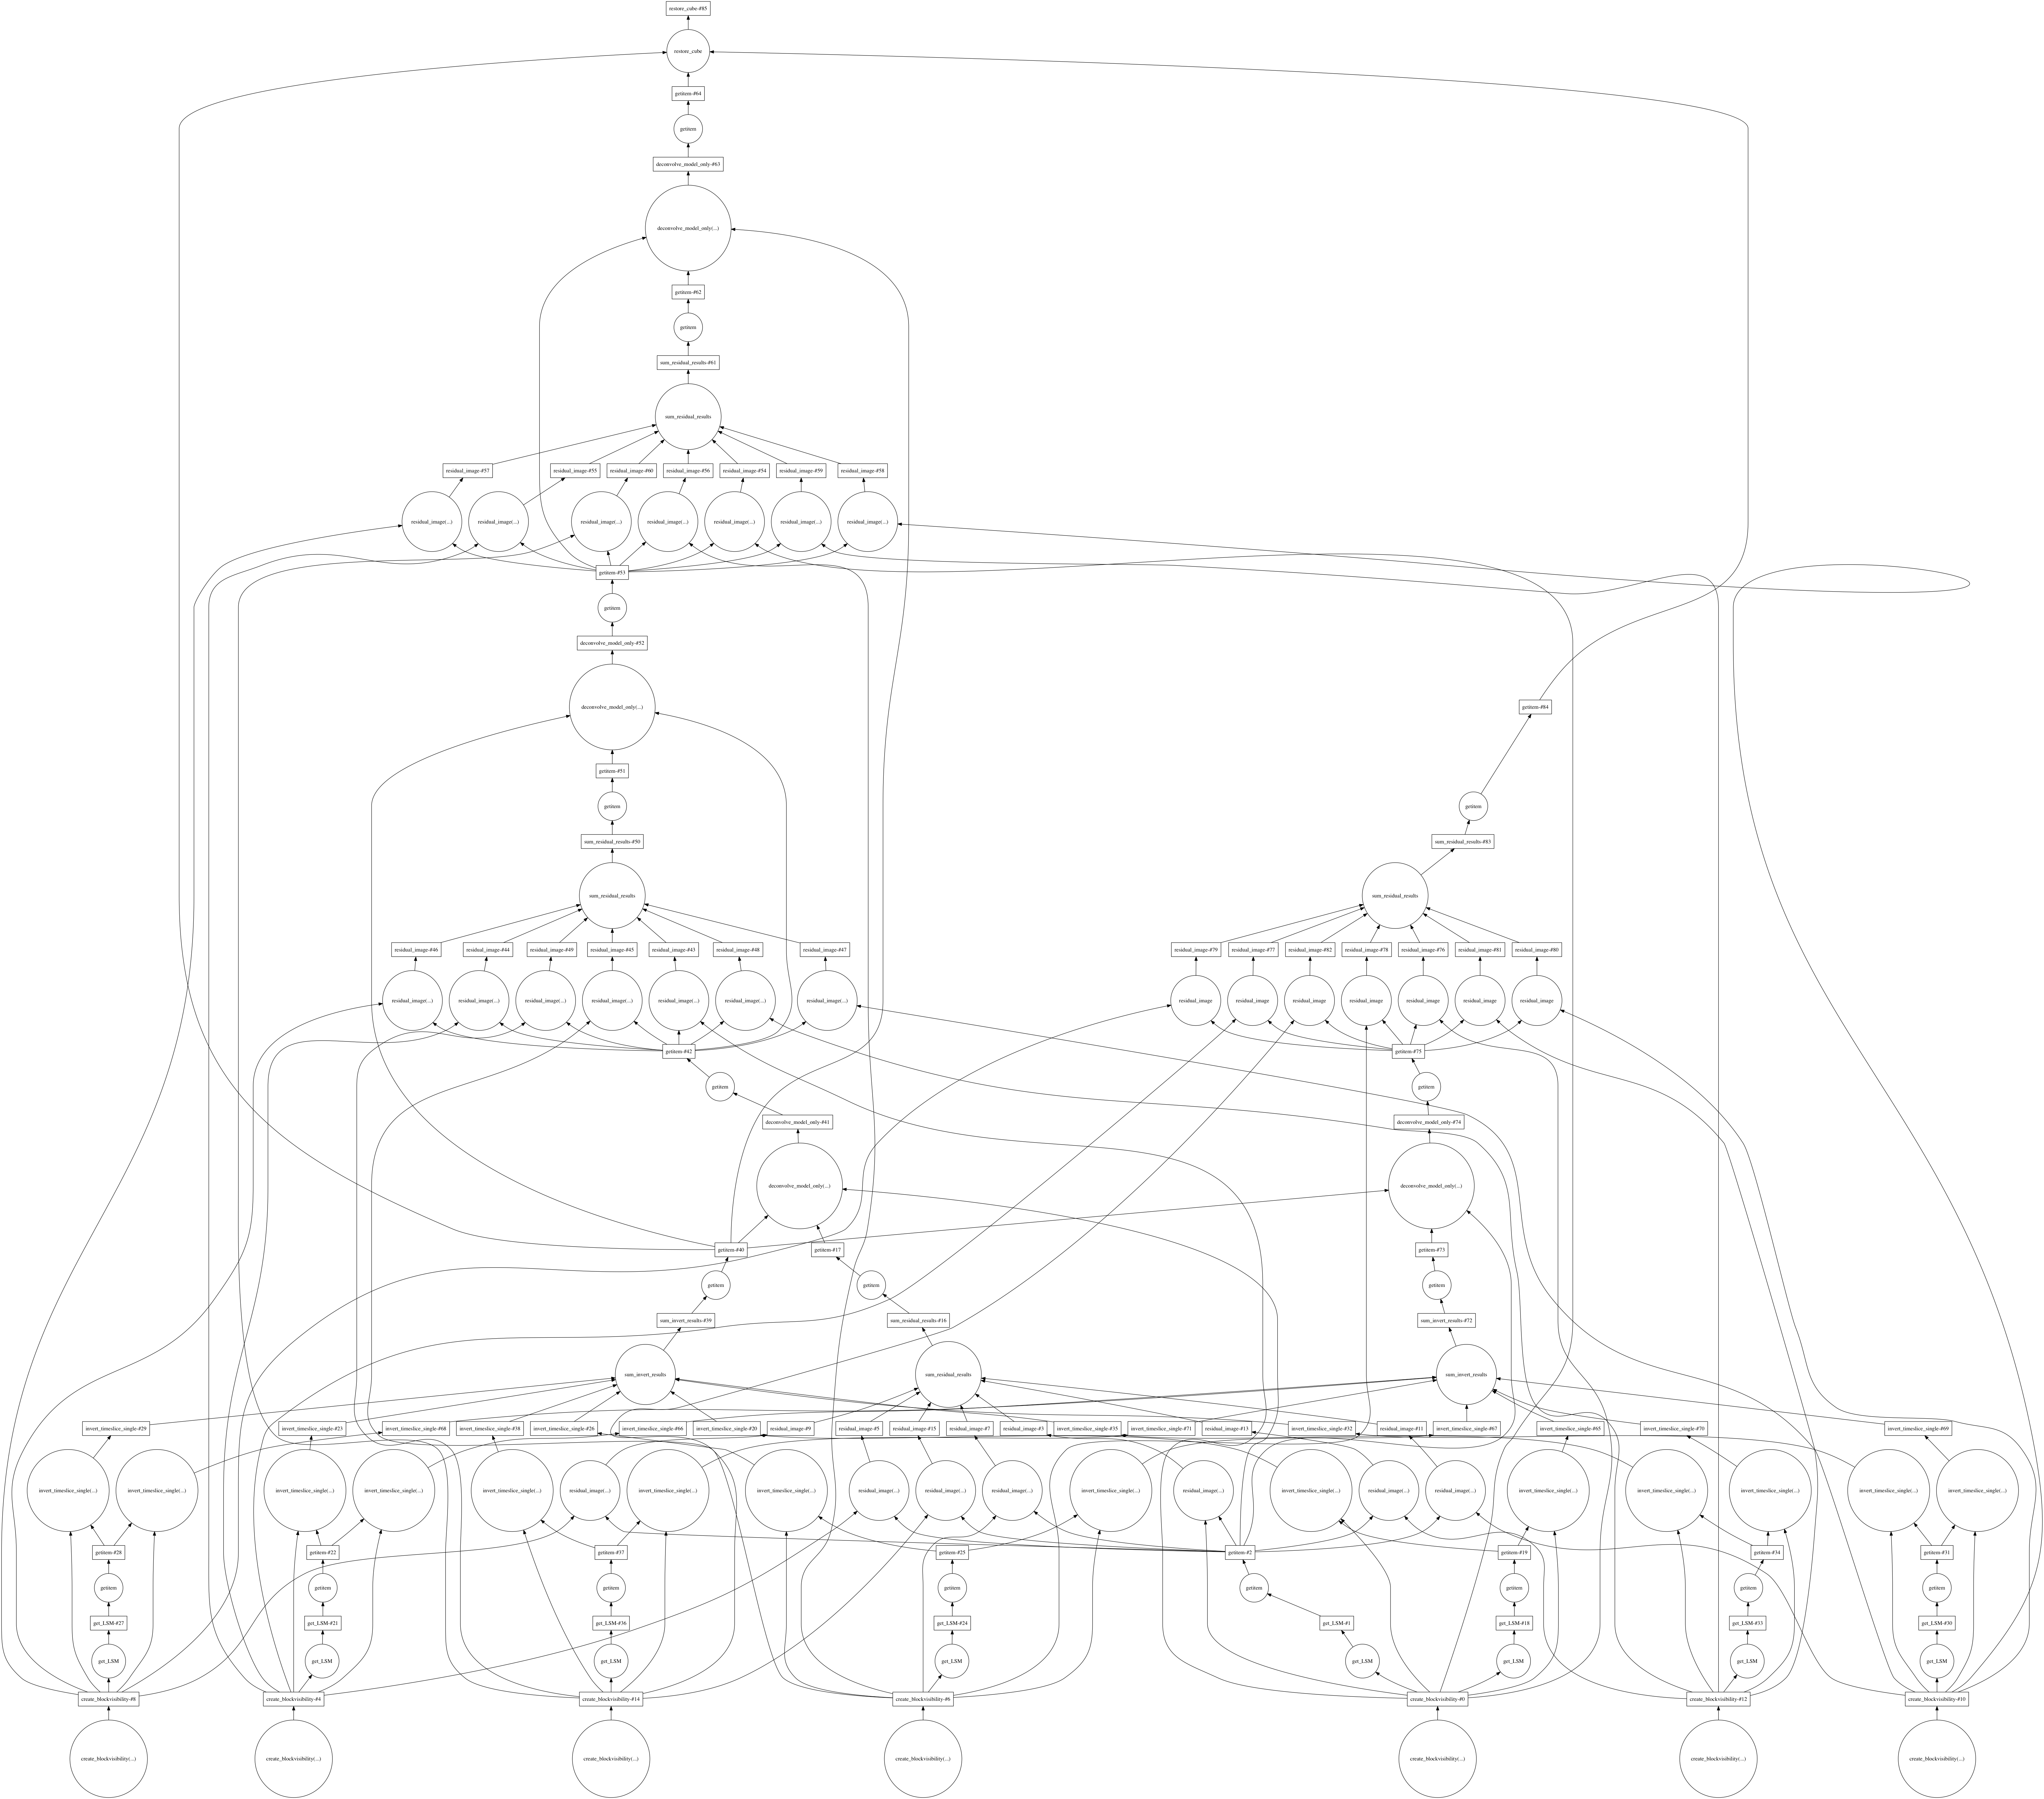

In [12]:
def create_restore_graph(solution_graph, psf_graph, residual_graph, **kwargs):
    return delayed(restore_cube, pure=True)(solution_graph[0], psf_graph[0], residual_graph[0], **kwargs)

restore_graph = create_restore_graph(solution_graph, psf_graph, residual_graph)
restore_graph.visualize()

Finally we can execute the restore_graph to obtain the result

create_visibility: 1 rows, 0.001 GB
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 396.276693 wavelengths
create_image_from_visibility: Critical cellsize = 0.001262 radians, 0.072293 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_visibility: 1 rows, 0.001 GB
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 106666666.66666667 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 396.276693 wavelengths
create_image_from_visibility: Critical cellsize = 0.001262 radians, 0.072293 degrees
create_image_from_visibility: Cellsize

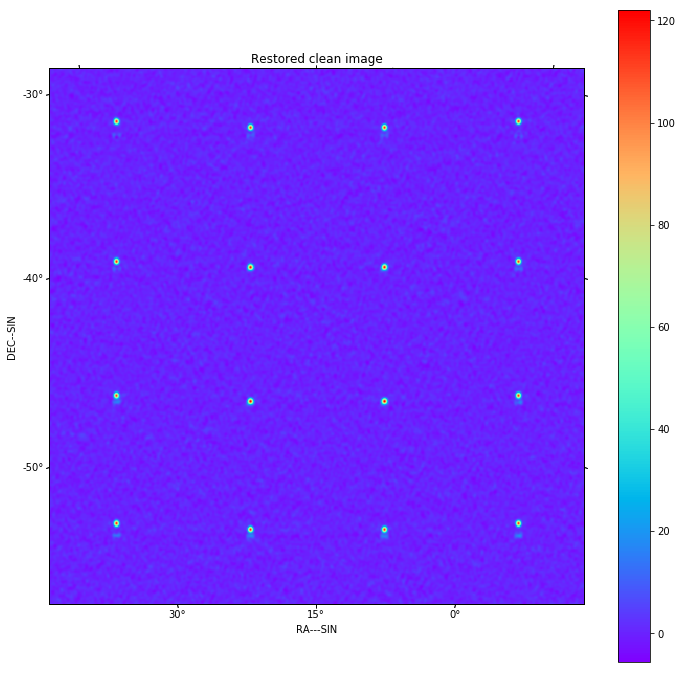

In [13]:
result=restore_graph.compute()
f=show_image(result, title='Restored clean image')
print(qa_image(result, context='Restored clean image'))